## Clustering
G. Richards (2016), based on materials from Ivezic, Vanderplas, Leighly, and Nathalie Thibert.

[Clustering](https://en.wikipedia.org/wiki/Cluster_analysis) algorithms attempt to group together like objects in a data set.  This process allows us to put new objects into the resulting classes and to identify rare objects that do not fit any particular mold.  Clustering is inherently an "unsupervised" process as we do not know the classification of the objects.  Since we have no metric for determining when we are right, it is a bit of a black art, but it also can be very powerful.  Scikit-Learn's clustering suite is summarized at [http://scikit-learn.org/stable/modules/clustering.html](http://scikit-learn.org/stable/modules/clustering.html).

### $K$-Means Clustering

We start with ["$K$-means" clustering](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html), which is one of the simplest methods.  "$K$-means" seeks to minimize the following

$$\sum_{k=1}^{K}\sum_{i\in C_k}||x_i - \mu_k||^2$$

where $\mu_k = \frac{1}{N_k}\sum_{i\in C_k} x_i$

This says to
  * Take every object in class $C_k$ (as determined by which centroid it is closest to, specifically $C_k(x_i) = \arg \min_k ||x_i-\mu_k||)$
  * Compute the mean of the objects in that class
  * Subtract that mean from each member of that class and square the norm
  * Do that for each class and sum
  * Shift the centroids of the *pre-determined* number of classes until this sum is minimized
  * Do this multiple times with different starting centroids and take the result with the minimum sum

A typical call will look something like this

In [3]:
# Execute this cell
import numpy as np
from sklearn.cluster import KMeans

X = np.random.normal(size=(1000,2)) #1000 points in 2D
clf = KMeans(n_clusters=3) #Try 3 clusters to start with
clf.fit(X)
centers=clf.cluster_centers_ #location of the clusters
labels=clf.predict(X) #labels for each of the points

# To get some information on these try:
KMeans?
# help(clf)

Here is an example with the same data that we used for GMM.  Note how the background shifts the centroids from what you might expect.  So, the mixture model might work better in this case.

However, one might consider runnig the K-means algorithm in order to find a suitable initialization for GMM.  Do you think that might have helped with our mis-behaving GMM example?

[[-0.50858331  0.25005719]]


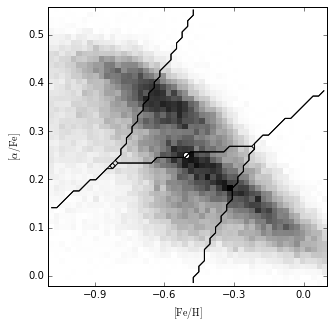

In [18]:
# Execute this cell
# Based on Ivezic, Figure 6.13
# GTR fixed bug by changing preprocessing.Scaler() to preprocessing.StandardScaler()
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Ellipse
from scipy.stats import norm

from sklearn.cluster import KMeans
from sklearn import preprocessing

from astroML.datasets import fetch_sdss_sspp

#------------------------------------------------------------
# Get data
data = fetch_sdss_sspp(cleaned=True)
# Remove some outliers
data = data[~((data['alphFe'] > 0.4) & (data['FeH'] > -0.3))]

X = np.vstack([data['FeH'], data['alphFe']]).T

# truncate dataset for speed
X = X[::5]

#------------------------------------------------------------
# Compute a 2D histogram  of the input
H, FeH_bins, alphFe_bins = np.histogram2d(data['FeH'], data['alphFe'], 50)

#------------------------------------------------------------
# Compute the KMeans clustering
n_clusters = 4

scaler = preprocessing.StandardScaler()
clf = KMeans(n_clusters)
clf.fit(scaler.fit_transform(X))

ms = MeanShift(bandwidth=1.0) #can also specify with no bandwidth
MeanShift?
ms.fit(X)
centers = ms.cluster_centers_
labels = ms.labels_
print centers

#------------------------------------------------------------
# Visualize the results
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot()

# plot density
ax = plt.axes()
ax.imshow(H.T, origin='lower', interpolation='nearest', aspect='auto',
          extent=[FeH_bins[0], FeH_bins[-1],
                  alphFe_bins[0], alphFe_bins[-1]],
          cmap=plt.cm.binary)

# plot cluster centers
cluster_centers = scaler.inverse_transform(clf.cluster_centers_)
ax.scatter(centers[:, 0], centers[:, 1],
           s=40, c='w', edgecolors='k')

# plot cluster boundaries
# using a fancy way to compute the average of the left and right edges of each bin
FeH_centers = 0.5 * (FeH_bins[1:] + FeH_bins[:-1])
alphFe_centers = 0.5 * (alphFe_bins[1:] + alphFe_bins[:-1])

Xgrid = np.meshgrid(FeH_centers, alphFe_centers)
Xgrid = np.array(Xgrid).reshape((2, 50 * 50)).T

H = clf.predict(scaler.transform(Xgrid)).reshape((50, 50))

for i in range(n_clusters):
    Hcp = H.copy()
    flag = (Hcp == i)
    Hcp[flag] = 1
    Hcp[~flag] = 0

    ax.contour(FeH_centers, alphFe_centers, Hcp, [-0.5, 0.5],
               linewidths=1, colors='k')

ax.xaxis.set_major_locator(plt.MultipleLocator(0.3))
ax.set_xlim(-1.101, 0.101)
ax.set_ylim(alphFe_bins[0], alphFe_bins[-1])

ax.set_xlabel(r'$\rm [Fe/H]$')
ax.set_ylabel(r'$\rm [\alpha/Fe]$')

plt.show()

A few things to note
* We scaled the data before running K-Means
* We had to *un*scale the data to plot the centers
* Plotting the cluster boundaries is not straightforward, but this gives you an example to work with

Another clustering algorithm is [Mean Shift](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.MeanShift.html).  It finds local modes in the peaks of a nonparametric density estimate (like KDE) and identifies each data point with the closest peak.  

Its call looks like:

In [9]:
# Execute this cell
import numpy as np
from sklearn.cluster import MeanShift

X = np.random.normal(size=(1000,2))
ms = MeanShift(bandwidth=1.0) #can also specify with no bandwidth
ms.fit(X)
centers = ms.cluster_centers_
labels = ms.labels_
print centers

[[ 0.08357607  0.16735316]]


Try replacing the $K$-means algorithm in the figure above with Mean shift.  Call it with `bin_seeding=True` to speed things up a bit.  

Here is an example using some real data provided by Prof. Cruz.

In [10]:
# Execute the next few cells
from astropy.table import Table
t = Table.read('data/cruz_all_dist.dat', format="ascii")

# Just something that you should know that you can do
t[::10000].show_in_notebook()

idx,col1,col2,col3,col4,col5
0,0,13.0363603913,-0.110234866494,9.04241732317,0.0
1,10000,9.02369695415,0.829321431489,6.83319319973,6.60629606247
2,20000,8.91859322147,0.0767433577768,6.48659468248,6.34498214722
3,30000,7.77121905894,-0.551283676943,6.83032101121,5.60742139816
4,40000,5.76039846137,-0.0708422162915,6.62395846477,5.15574979782
5,50000,9.41512902968,-0.0510225581515,7.13210019373,5.60693597794
6,60000,12.2001243155,-0.0440451156979,8.01902407798,5.00530338287
7,70000,11.5533454994,0.138134291888,7.04389241378,5.71916437149
8,80000,12.2994472589,-0.115206217891,7.61990666572,4.7162733078
9,90000,11.395932754,0.820936293606,7.15394340425,5.14604997635


In [11]:
# Turn these data into a properly formatted Scikit-Learn array
X = np.vstack([ t['col2'], t['col3'], t['col4'], t['col5'] ]).T
print X

[[ 13.03636039  -0.11023487   9.04241732   0.        ]
 [ 13.33267828  -0.10360584   9.35453197   0.68184119]
 [ 13.14338559  -0.16142859   9.30932842   0.82017946]
 ..., 
 [  6.77437708  -0.12553107   5.54210446   7.41862726]
 [  6.71834403   0.04474092   5.56965196   7.44040775]
 [  7.02729337   0.12547728   5.55979252   7.49615526]]


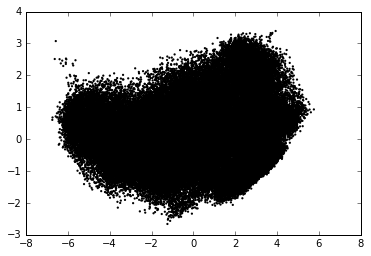

In [15]:
# Project onto 2 axes with PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=2) # 2 components
pca.fit(X) # Do the fitting

X_reduced = pca.transform(X)

plt.scatter(X_reduced[:, 0], X_reduced[:, 1], marker=".", color='k', edgecolors='None')

In [19]:
# Compute the KMeans clustering
n_clusters = 6

scaler = preprocessing.StandardScaler()
clf = KMeans(n_clusters)
clf.fit(scaler.fit_transform(X_reduced))

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=6, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)

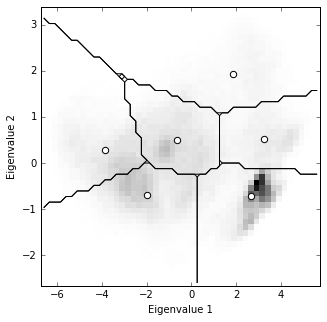

In [20]:
# Make some plots
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot()

# Compute a 2D histogram  of the input
H, xedges, yedges = np.histogram2d(X_reduced[:,0], X_reduced[:,1], 50)

# plot density
ax = plt.axes()
ax.imshow(H.T, origin='lower', interpolation='nearest', aspect='auto',
          extent=[xedges[0], xedges[-1],
                  yedges[0], yedges[-1]],
          cmap=plt.cm.binary)

# plot cluster centers
cluster_centers = scaler.inverse_transform(clf.cluster_centers_)
ax.scatter(cluster_centers[:, 0], cluster_centers[:, 1],
           s=40, c='w', edgecolors='k')

# plot cluster boundaries
x_centers = 0.5 * (xedges[1:] + xedges[:-1])
y_centers = 0.5 * (yedges[1:] + yedges[:-1])

Xgrid = np.meshgrid(x_centers, y_centers)
Xgrid = np.array(Xgrid).reshape((2, 50 * 50)).T

H = clf.predict(scaler.transform(Xgrid)).reshape((50, 50))

for i in range(n_clusters):
    Hcp = H.copy()
    flag = (Hcp == i)
    Hcp[flag] = 1
    Hcp[~flag] = 0

    ax.contour(x_centers, y_centers, Hcp, [-0.5, 0.5],
               linewidths=1, colors='k')

#ax.xaxis.set_major_locator(plt.MultipleLocator(0.3))
ax.set_xlim(xedges[0], xedges[-1])
ax.set_ylim(yedges[0], yedges[-1])

ax.set_xlabel('Eigenvalue 1')
ax.set_ylabel('Eigenvalue 2')

plt.savefig('cruz.png')
plt.show()

## Hierarchical Clustering

In [Hierarchical Clustering](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html), we don't specify the number of clusters ahead of time, we start with $N$ clusters representing each data point.  Then the most similar clusters are joined together, the process repeating until some threshhold is reached.  Actually the process can go in the other direction as well.  What results is what is called a *dendrogram*, an example of which is shown below.

![](https://onlinecourses.science.psu.edu/stat505/sites/onlinecourses.science.psu.edu.stat505/files/lesson12/dendogram_example.gif)

Clusters are merged at each step according to which are "nearest" to each other---where the definition of nearest needs to be specified.  A typical choice results in what is called a "minimum spanning tree" (which can be quite slow for large data sets).  Some threshhold needs to be specified to tell the process where to stop (e.g., we are going to treat the green and red objects in the example above as separate clusters).  

Below is an example call.

In [21]:
# Execute this cell
import numpy
from scipy.sparse.csgraph import minimum_spanning_tree
from sklearn.neighbors import kneighbors_graph

X = np.random.random((1000,2))
G = kneighbors_graph(X, n_neighbors=10, mode='distance')
T = minimum_spanning_tree(G)

OK, but that's all that the book give us.  There is nothing about what to do with `G` and `T`.  So, instead I'm going to show you a really cool example from a colleague.  In this example Nathalie Thibert is taking spectroscopic data of a certain sub-class of quasars.  She is then grouping the objects into "like" bins using a hierarchical clustering algorithm.  The code below is based on the [scipy implementation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html) and takes us through both the analysis and visualization of the data.  It makes use of the [Python Data Analysis Library (pandas)](http://pandas.pydata.org/) and ['pickled'](https://docs.python.org/2/library/pickle.html), 
data both of which we have not talked about.

For another detailed example of hierarchical clustering, see [https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/](https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/).

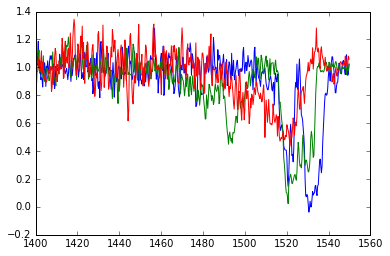

In [23]:
# %load code/thibert_cluster1.py
## Hierarchical Clustering Example: BAL Quasar UV Spectra (pre-reduced)
## Author: Nathalie C. M. Thibert (Saint Mary's University), modified from
## 	   code by Mark Daley (Western University)
##
## Method: Agglomerative Hierarchical Clustering
## Distance Metric: Complete Linkage
## Data: 100 BAL Quasar UV Spectra over ~1400-1550 Ang (i.e., the C IV BAL) 
##	 Spectra are already in rest-frame, normalized to the local continuum 
## 	 and emission lines, and resampled to a common wavelength grid. 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pylab

# import clustering algorithms from scipy
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import pdist, squareform

# Import pickled BAL quasar data.
data = pd.read_pickle('./data/balquasar_data.pkl') # Should have 500 wavelength values and 100 spectra.

# Over plot some example spectra
wl = np.arange(1400.1,1549.8,0.3)
spec0 = data.T.iloc[0] # You can change the index to see different spectra (choose 0,1,2,...,99).
spec5 = data.T.iloc[5]
spec7 = data.T.iloc[7]
plt.figure() 
plt.plot(wl,spec0)
plt.plot(wl,spec5)
plt.plot(wl,spec7)
plt.show()


/home/vbaker/anaconda2/lib/python2.7/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


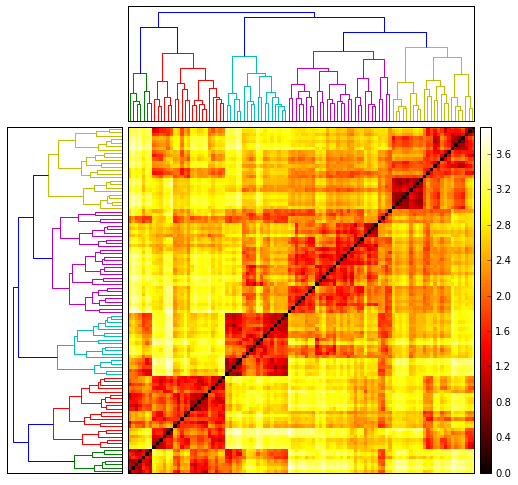

In [25]:
# %load code/thibert_cluster2.py
## Hierarchical Clustering Example: BAL Quasar UV Spectra (pre-reduced)
## Author: Nathalie C. M. Thibert (Saint Mary's University), modified from
## 	   code by Mark Daley (Western University)
##
## Method: Agglomerative Hierarchical Clustering
## Distance Metric: Complete Linkage
## Data: 100 BAL Quasar UV Spectra over ~1400-1550 Ang (i.e., the C IV BAL) 
##	 Spectra are already in rest-frame, normalized to the local continuum 
## 	 and emission lines, and resampled to a common wavelength grid. 


# Compute Pearson correlation matrix for 100 spectra. 
# Each element is a pairwise comparison b/w two spectra.
c = data.corr() # Should have 100 rows and 100 columns.

# Compute absolute-valued Pearson distance matrix.
dp = 1.0 - np.abs(c)

# Compute Euclidean distance matrix for the first dendrogram
de1 = squareform(pdist(dp,metric='euclidean')) 

# Do it again for the second dendrogram
de2 = squareform(pdist(dp.T,metric='euclidean'))

# Start the dendrogram plot.
f = plt.figure(figsize=(8, 8))

# Add the first dendrogram (on the left side)
ax1 = f.add_axes([0.09, 0.1, 0.2, 0.6])
Y = linkage(de1, method='complete') # This is where the hierarchical clustering takes place.
Z1 = dendrogram(Y, orientation='left',show_leaf_counts=False, no_labels=True) # Plots dendrogram.
ax1.set_xticks([])
ax1.set_yticks([])

# Add the second dendrogram (on the top)
ax2 = f.add_axes([0.3, 0.71, 0.6, 0.2])
Y = linkage(de2, method='complete')
Z2 = dendrogram(Y,show_leaf_counts=False, no_labels=True)
ax2.set_xticks([])
ax2.set_yticks([])

# Add the (main) plot of the (clustered) Euclidean distance matrix.
axmatrix = f.add_axes([0.3, 0.1, 0.6, 0.6])
idx1 = Z1['leaves']
idx2 = Z2['leaves']
D = de1[idx1, :]
D = D[:, idx2]
im = axmatrix.matshow(D, aspect='auto', origin='lower', cmap='hot')
axmatrix.set_xticks([])
axmatrix.set_yticks([])
    
axcolor = f.add_axes([0.91,0.1,0.02,0.6])
pylab.colorbar(im,cax=axcolor)
f.show()

## NOTE: The colours in the dendrograms correspond to a flat clustering given 
##	 the default distance threshold in Python.



Note that the side and top dendrograms are the same data.  It is just that the 2-D visualization better lets us see what groups go together.

I don't pretend to fully understand each step of this process, but the end result is really cool and I think that there is enough here to get you started if we were interested in trying to implement it.

Summary of Chapter 6 methods from Ivezic Table 6.1 

|Method          |Accuracy|Interpretability|Simplicity|Speed|
|----------------|--------|----------------|----------|-----|
|K-nearest Neighbor| H | H | H | M |
|Kernel Density Estimation| H | H | H | H |
|Gaussian Mixture Models| H | M | M | M |
|Extreme Deconvolution| H | H | M | M |
||||||
|K-Means| L | M | H | M |
|Max-radius minimization| L | M | M | M |
|Mean shift| M | H | H | M |
|Hierarchical Clustering| H | L | L | L |